In [1]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import pyro
from utils import * 

Define prior on $\theta$

In [14]:
mu_theta =torch.tensor(6.)
sigma2_theta =torch.tensor(1.)*0.25
prior = torch.distributions.Normal(mu_theta, torch.sqrt(sigma2_theta))

Generate $D_\theta$ according to some prior distribution

In [19]:
n_D = 10
D_theta =torch.linspace(-1,1, n_D)

Generate $D_x$ according to some unknown linear $f(D_\theta)$

In [20]:
mu_phi = torch.zeros(2)
Sigma_phi = torch.eye(2)
phi0 = torch.distributions.MultivariateNormal(mu_phi, Sigma_phi).sample()
sigma2_simulateur = torch.tensor(.25)
f = lambda y: phi0[0]*y+phi0[1]
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*torch.sqrt(sigma2_simulateur)

D_x = simulateur(D_theta)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [21]:
theta_0 = prior.sample()
print('theta_0 = ' + str(theta_0.item()))
n_x0= 1
x0 = simulateur(theta_0.repeat(n_x0))

theta_0 = 6.304184436798096


Scatter plot of $D$, unknown linear model $f$, histogram of $x_0$

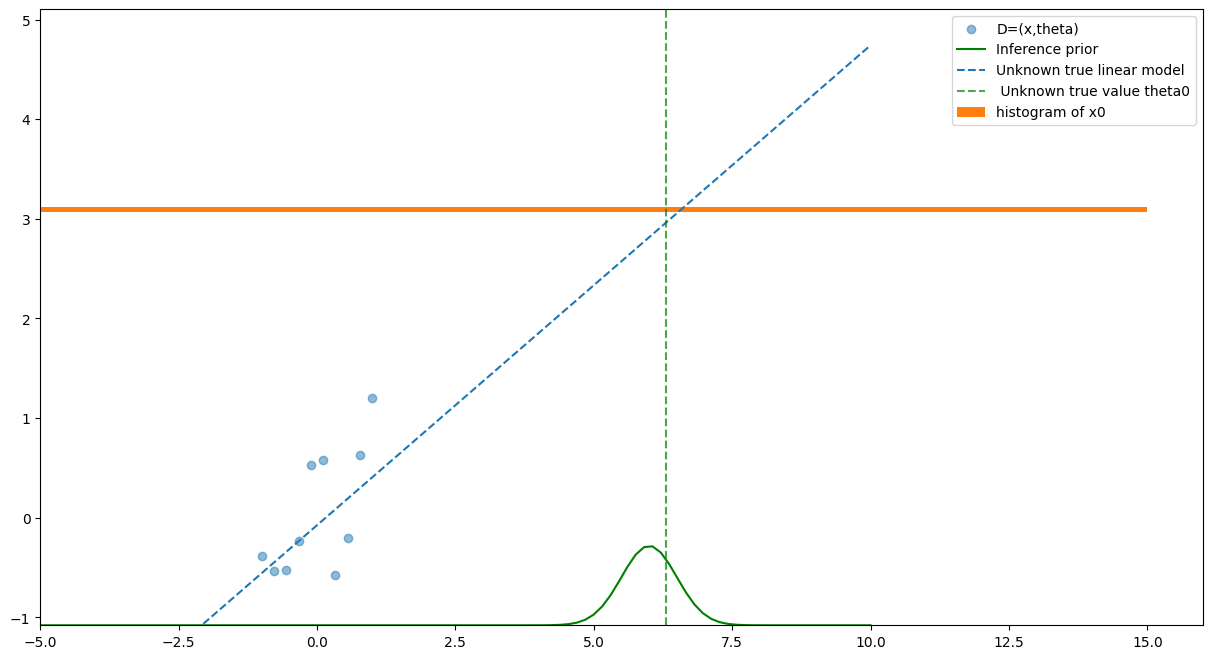

In [22]:
plt.figure(figsize = (15,8))
y_min = torch.min(torch.cat([D_x,x0])) - 0.5
plt.scatter(D_theta.numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
tt = torch.linspace(-5,10,100)
plt.plot(tt, y_min + torch.exp(prior.log_prob(tt)), color = 'green', label='Inference prior')
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = 'Unknown true linear model')
plt.axvline(theta_0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0')
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
plt.ylim(y_min,)
plt.legend()

In [23]:
class bayesian_linear_regression:
    def __init__(self,sigma2_simulateur, mu_theta = torch.tensor(0.), sigma2_theta = torch.tensor(1.), mu_phi = torch.zeros(2), Sigma_phi = torch.eye(2)):        
        self.sigma2_simulateur = sigma2_simulateur
        self.mu_theta = mu_theta
        self.sigma2_theta = sigma2_theta 
        self.mu_phi = mu_phi
        self.Sigma_phi = Sigma_phi
    
    def compute_theta_given_x0_phi_moments(self,x0,phi):
        sigma_theta_given_x0_phi = 1/(1/self.sigma2_theta + (x0.shape[0]*phi[0]**2)/self.sigma2_simulateur)
        mu_theta_given_x0_phi = sigma_theta_given_x0_phi*(self.mu_theta/self.sigma2_theta + phi[0]*torch.sum(x0 - phi[1])/self.sigma2_simulateur)
        return mu_theta_given_x0_phi, sigma_theta_given_x0_phi 
        
    def compute_phi_given_D_moments(self, D_theta, D_x):
        assert D_theta.shape[0] == D_x.shape[0],'Mismatch in number samples'
        if D_theta.shape[0]>=1:
            temp = torch.cat([D_theta.unsqueeze(-1), torch.ones(D_theta.shape[0],1)], dim = -1)
            Sigma_phi_given_D = torch.inverse(temp.T@temp/self.sigma2_simulateur + torch.inverse(self.Sigma_phi))
            mu_phi_given_D = Sigma_phi_given_D@(D_x@temp/self.sigma2_simulateur+ torch.inverse(self.Sigma_phi)@self.mu_phi)
        else:
            mu_phi_given_D, Sigma_phi_given_D = self.mu_phi, self.sigma_phi 
        return mu_phi_given_D,Sigma_phi_given_D
        
    def log_joint_distribution(self, theta, phi):
        log_prior = torch.distributions.Normal(self.mu_theta, torch.sqrt(self.sigma2_theta)).log_prob(theta)
        augmented_theta = torch.cat([theta.unsqueeze(-1), torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        log_parameter_posterior = self.parameter_posterior_distribution.log_prob(phi)
        return log_parameter_posterior+log_prior+log_likelihood
    
    def compute_x_given_theta_D_moments(self, theta, D_theta,D_x): 
        mean_phi_given_D, Sigma_phi_given_D = self.compute_phi_given_D_moments(D_theta, D_x)
        gamma = torch.cat([theta.unsqueeze(-1), torch.ones_like(theta).unsqueeze(-1)], dim = -1)
        mean = gamma@mean_phi_given_D
        sigma2 = (gamma.unsqueeze(-2)@Sigma_phi_given_D@gamma.unsqueeze(-1)).reshape_as(theta) + self.sigma2_simulateur
        return mean, sigma2
    
    def marginal_log_posterior(self, theta, x0, D_theta, D_x):
        mean_phi_given_D, Sigma_phi_given_D = self.compute_phi_given_D_moments(D_theta, D_x)
        gamma = torch.cat([theta.unsqueeze(-1), torch.ones_like(theta).unsqueeze(-1)], dim = -1).unsqueeze(-2).repeat(1,x0.shape[0],1)
        prior = torch.distributions.Normal(self.mu_theta, self.sigma2_theta).log_prob(theta)
        likelihood = torch.distributions.MultivariateNormal(gamma@mean_phi_given_D,gamma@Sigma_phi_given_D@gamma.mT + self.sigma2_simulateur*torch.eye(x0.shape[0])).log_prob(x0.unsqueeze(0).repeat(theta.shape[0],1))
        return prior + likelihood

blr = bayesian_linear_regression(sigma2_simulateur, mu_theta, sigma2_theta)


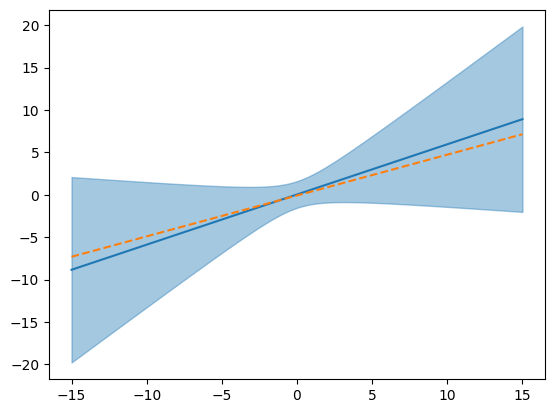

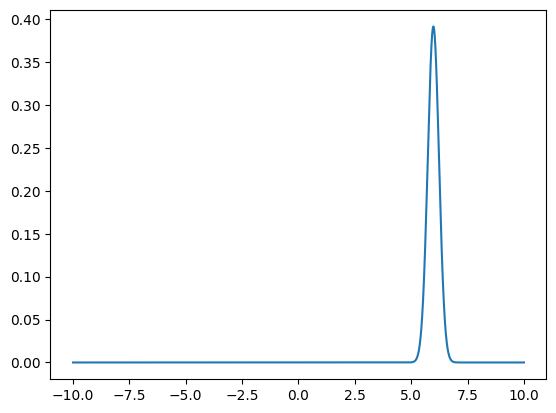

In [24]:
tt= torch.linspace(-15,15,100)
mean, var = blr.compute_x_given_theta_D_moments(tt, D_theta, D_x)
plt.plot(tt, mean)
plt.fill_between(tt, mean-3*torch.sqrt(var), mean + 3*torch.sqrt(var), color = 'C0', alpha = .4)
plt.plot(tt, f(tt), linestyle = '--')
plt.show()

tt = torch.linspace(-10,10,5000)
plt.plot(tt, torch.exp(blr.marginal_log_posterior(tt,x0, D_theta, D_x)))
plt.show()

Sample joint with Gibbs sampling

In [25]:
from tqdm import tqdm
def sample_marginal_IMH(number_steps, number_chains):
    current_theta = prior.sample([number_chains])
    pbar = tqdm(range(number_steps))
    for _ in pbar:
        proposed_theta = prior.sample([number_chains])
        acceptance_log_prob = blr.marginal_log_posterior(proposed_theta, x0, D_theta, D_x)- blr.marginal_log_posterior(current_theta, x0, D_theta, D_x)
        mask = torch.rand(number_chains) < torch.exp(acceptance_log_prob)
        current_theta = (mask)*proposed_theta + (~mask)*current_theta
        pbar.set_postfix_str(str((1.*mask).mean()))
    return current_theta
theta_samples_marginal = sample_marginal_IMH(200,1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.26it/s, tensor(0.5160)]


In [10]:
mean_phi_D, Sigma_phi_D = blr.compute_phi_given_D_moments(D_theta, D_x)
current_phi = torch.distributions.MultivariateNormal(mean_phi_D,Sigma_phi_D).sample()

mean_theta_x0_phi, var_theta_x0_phi = blr.compute_theta_given_x0_phi_moments(x0,current_phi)
current_theta = torch.distributions.Normal(mean_theta_x0_phi, torch.sqrt(var_theta_x0_phi)).sample()
print(current_theta)
current_theta = prior.sample()
list_theta_gibbs = []
list_phi_gibbs = []
for t in tqdm(range(10000)):
    current_Theta = current_theta.repeat(x0.shape[0])
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_D_plus, sigma_phi_D_plus = blr.compute_phi_given_D_moments(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D_plus, sigma_phi_D_plus).sample()
    mu_theta_given_x0_phi, sigma2_theta_given_x0_phi = blr.compute_theta_given_x0_phi_moments(x0,current_phi)
    current_theta = torch.distributions.Normal(mu_theta_given_x0_phi, sigma2_theta_given_x0_phi).sample()
    list_theta_gibbs.append(current_theta)
    list_phi_gibbs.append(current_phi)
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_theta_gibbs).unsqueeze(1),chain_dim = 1, sample_dim =0))
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_phi_gibbs)))

tensor(5.6795)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1282.55it/s]


ESS theta  tensor(67.1967)
ESS theta  tensor(-7084.3291)


In [11]:
current_Theta = prior.sample([n_x0])
list_theta_weird_gibbs = []
list_phi_weird_gibbs = []
for t in tqdm(range(10000)):
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_given_Dplus, Sigma_phi_given_Dplus = blr.compute_phi_given_D_moments(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_given_Dplus, Sigma_phi_given_Dplus).sample()
    mu_theta_given_x0_phi, sigma2_theta_given_x0_phi = blr.compute_theta_given_x0_phi_moments(x0,current_phi)
    current_Theta = torch.distributions.Normal(mu_theta_given_x0_phi, sigma2_theta_given_x0_phi).sample([n_x0]).squeeze(-1)
    list_theta_weird_gibbs.append(current_Theta[0])
    list_phi_weird_gibbs.append(current_phi)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1562.93it/s]


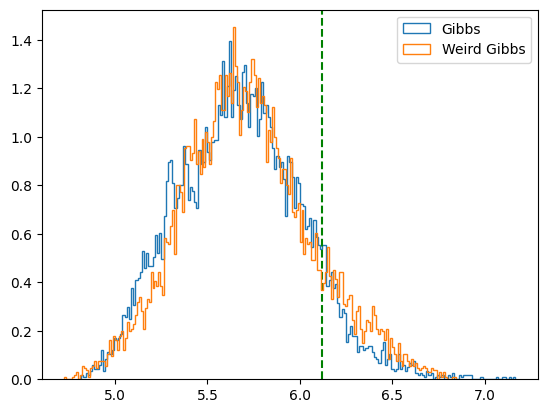

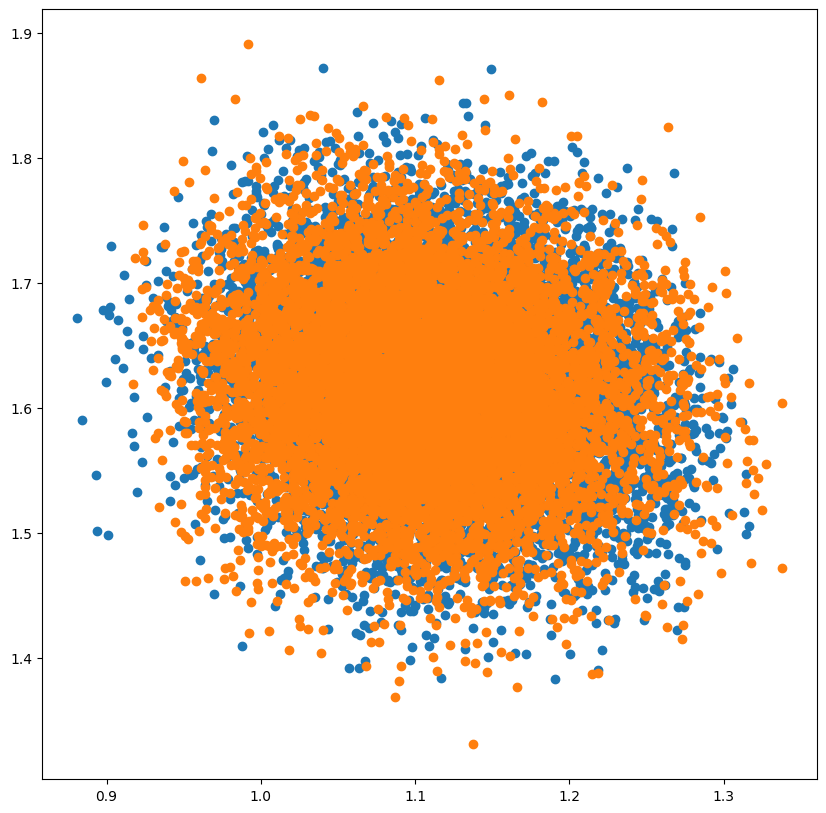

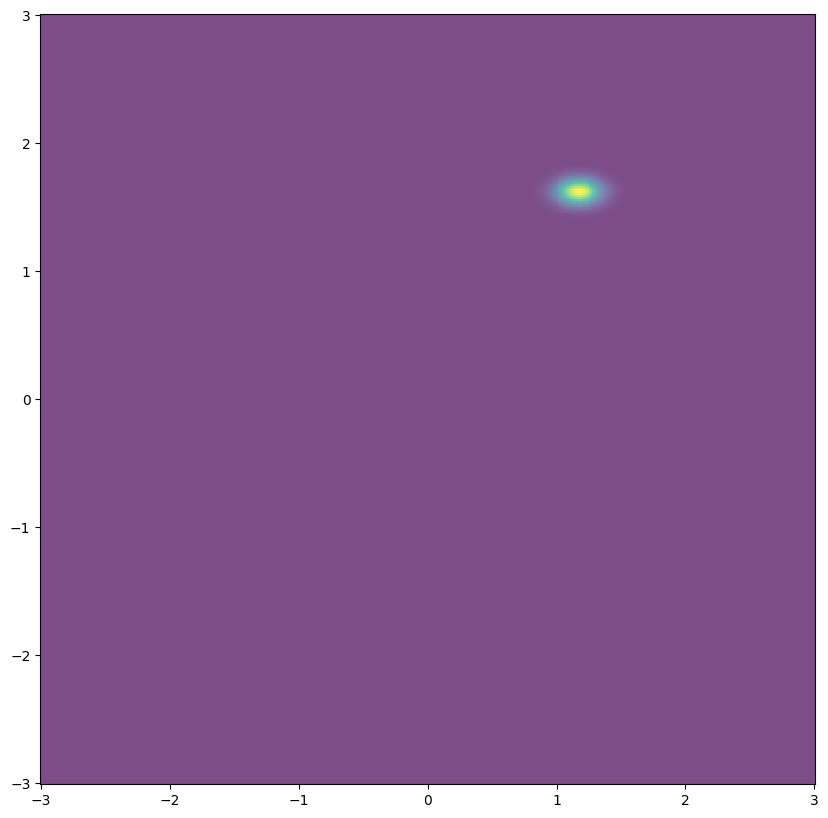

In [12]:
models_phi_gibbs = torch.stack(list_phi_gibbs, dim=0)
models_phi_weird_gibbs = torch.stack(list_phi_weird_gibbs, dim=0)
total_phi = torch.stack(list_phi_gibbs + list_phi_weird_gibbs)
hist=plt.hist(torch.stack(list_theta_gibbs, dim = 0).numpy(), bins= 200, label = 'Gibbs', histtype ='step', density = True)
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
hist=plt.hist(torch.stack(list_theta_weird_gibbs, dim = 0).numpy(), bins= 200, label ='Weird Gibbs', histtype ='step', density =True)
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
plt.scatter(models_phi_gibbs[:,0].numpy(), models_phi_gibbs[:,1].numpy(), label = 'gibbs samples')
plt.scatter(models_phi_weird_gibbs[:,0].numpy(), models_phi_weird_gibbs[:,1].numpy(), label = 'weird gibbs samples')
mean_phi_given_D, Sigma_phi_given_D = blr.compute_phi_given_D_moments(D_theta, D_x)
posterior_distribution = torch.distributions.MultivariateNormal(mean_phi_given_D, Sigma_phi_given_D)
plot_2d_function(lambda samples:torch.exp(posterior_distribution.log_prob(samples)), range = [[-3,3],[-3,3]], bins = (400,400))

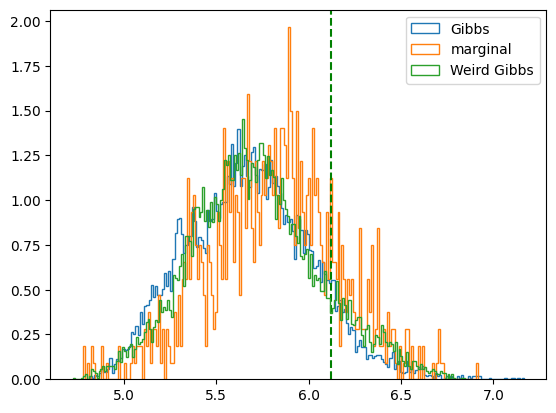

In [13]:
models_phi_gibbs = torch.stack(list_phi_gibbs, dim=0)
models_phi_weird_gibbs = torch.stack(list_phi_weird_gibbs, dim=0)
total_phi = torch.stack(list_phi_gibbs + list_phi_weird_gibbs)
hist=plt.hist(torch.stack(list_theta_gibbs, dim = 0).numpy(), bins= 200, label = 'Gibbs', histtype ='step', density = True)
hist=plt.hist(theta_samples_marginal.numpy(), density =True , histtype = 'step', label = 'marginal', bins = 200)
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
hist=plt.hist(torch.stack(list_theta_weird_gibbs, dim = 0).numpy(), bins= 200, label ='Weird Gibbs', histtype ='step', density =True)
plt.legend()
plt.show()


In [ ]:
theta_samples_marginal.shape